In [28]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-julia-old/altro_rocket/Project.toml`


In [29]:
using LinearAlgebra
using StaticArrays
using Printf
using Altro
using RobotDynamics
const RD = RobotDynamics
using TrajectoryOptimization
const TO = TrajectoryOptimization
using Plots
using ForwardDiff  # needed for @autodiff
using FiniteDiff   # needed for @autodiff
import RobotDynamics: AbstractModel
using RobotDynamics: @autodiff

In [30]:
#Define a Discrete Dynamics model using RobotDynamics.jl
@autodiff struct Pendulum <: RobotDynamics.DiscreteDynamics end

RD.state_dim(::Pendulum) = 2
RD.control_dim(::Pendulum) = 1

#RK4 integrator with free time and slack controls 
function RD.discrete_dynamics!(model::Pendulum, x_next, x, u, t, h)
    theta = x[1]
    theta_dot = x[2]
    theta_dot_dot = u[1] + 10*sin(theta)
    theta_dot_new = theta_dot + theta_dot_dot*h
    theta_new = theta + theta_dot_new*h
    x_next .= [theta_new, theta_dot_new]
    return nothing     
end
function RD.discrete_dynamics(model::Pendulum, x, u, t, h)    
    #T makes x_next the dual variable type in order to use ForwardDiff
    T = promote_type(eltype(x), eltype(u))
    x_next = zeros(T, size(x, 1))
    RD.discrete_dynamics!(model::Pendulum, x_next, x, u, t, h)
    return x_next
end
#redefine the copy function to work with discrete dynamics
function Base.copy(model::Pendulum)
    return Pendulum()
end

In [31]:
#Create the RobotDynamics model
model = Pendulum()

#obtain the size of the model (states, controls)
nx, nu = size(model)
N = 100
dt = 0.05
t_vec = dt*(0:N-1)
tf = (N-1)*dt
x0 = [3.0, 0.0]
xg = [0.0, 0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Qk = 1e1
Rk = 1e0
Qfk = 1e1

Q = Diagonal(@SVector fill(Float64(Qk), nx))
R = Diagonal(@SVector fill(Float64(Rk), nu))
Qf = Diagonal(@SVector fill(Float64(Qfk), nx))
obj = LQRObjective(Q,R,Qf,xg,N)

# CONSTRAINT
cons = ConstraintList(nx,nu,N)

ncx = 2*nx*1
ncu = 2*nu*1
ncg = 1

if ncg > 0
    add_constraint!(cons, GoalConstraint(xg), N)
end
if ncu > 0
    u_min = -3.0*ones(nu)
    u_max =  3.0*ones(nu)
    bnd = BoundConstraint(nx, nu, u_min=u_min, u_max=u_max)
    add_constraint!(cons, bnd, 1:N-1)
end
if ncx > 0
    # state is x y v θ
    x_min = [-100, -100.0]
    x_max = [100, 100.0]
    bnd1 = BoundConstraint(nx, nu, x_min=x_min, x_max=x_max)
    add_constraint!(cons, bnd1, 1:N)
end

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [[-0.1] for k = 1:N-1]
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

# SOLVE
prob = Problem(model, obj, x0, tf, xf=xg, constraints=cons, N=N, U0=U)

initial_controls!(prob, U)
rollout!(prob);

solver = ALTROSolver(prob)
set_options!(solver, projected_newton=false, verbose=0)
solve!(solver);
X_altro = states(solver)
U_altro = controls(solver);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 559
    Solve Time: 516.644449 (ms)

  Covergence
    Terminal Cost: 6959.1430493458365
    Terminal dJ: 0.0
    Terminal gradient: 0.022836188552852087
    Terminal constraint violation: 0.0015144179701425228
    Solve Status: NO_PROGRESS


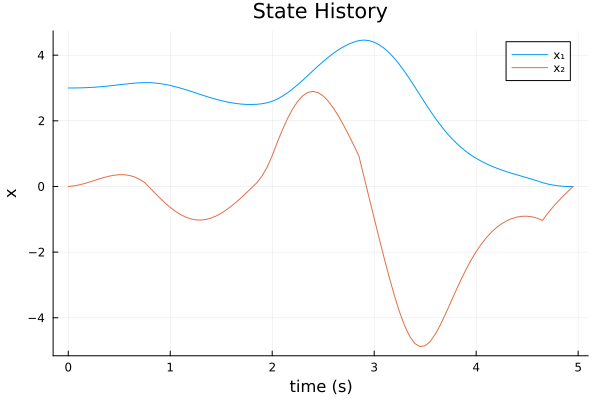

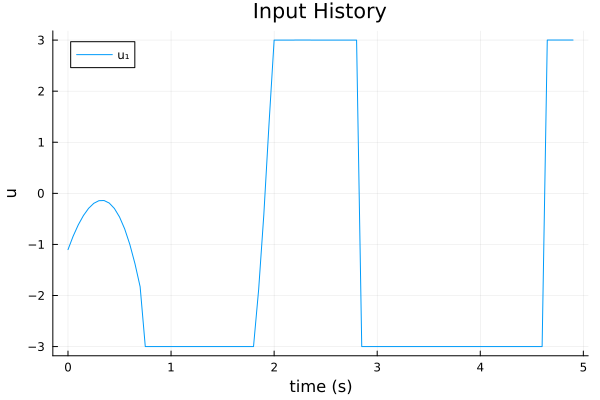

In [32]:
Un = hcat(Vector.(U_altro)...)
Xn = hcat(Vector.(X_altro)...)
display(plot(t_vec,Xn',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Un',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))